In [2]:
#Document Loader = directory_loader()

# Parameters for directory_loader:
#   glob: str = "**/*.md"           # Pattern to match Markdown files in all subdirectories
#   show_progress: bool = True      # Display a progress bar while loading files
#   use_multithreading: bool = True # Enable multithreading for faster loading
#   recursive: bool = True          # Recursively search subdirectories
#   silent_errors: bool = False     # Suppress errors during loading
#   loader_cls: Optional[Type] = None # Custom loader class for files
#   loader_kwargs: Optional[dict] = None # Additional kwargs for the loader class

"""
parameters:
    glob="**/*.md",                # Pattern to match Markdown files in all subdirectories
    show_progress=True,            # Display a progress bar while loading files
    use_multithreading=True,       # Enable multithreading for faster loading
    recursive=True,                # Recursively search subdirectories
    silent_errors=False,           # Suppress errors during loading
    loader_cls=TextLoader,         # Custom loader class for files
    loader_cls=PythonLoader
    loader_kwargs=None             # Additional kwargs for the loader class
    loader_kwargs=text_loader_kwargs
"""


'\nparameters:\n    glob="**/*.md",                # Pattern to match Markdown files in all subdirectories\n    show_progress=True,            # Display a progress bar while loading files\n    use_multithreading=True,       # Enable multithreading for faster loading\n    recursive=True,                # Recursively search subdirectories\n    silent_errors=False,           # Suppress errors during loading\n    loader_cls=TextLoader,         # Custom loader class for files\n    loader_cls=PythonLoader\n    loader_kwargs=None             # Additional kwargs for the loader class\n    loader_kwargs=text_loader_kwargs\n'

#### Document Loading

In [3]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
def document_loader(path):
    loader = DirectoryLoader(
        path="data",
        glob="**/*.txt",
        show_progress=True,
        use_multithreading=True,
        silent_errors=True,
        loader_cls=TextLoader
    )
    return loader.load()
docs = document_loader("data")
docs

100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


[Document(metadata={'source': 'data\\usa.txt'}, page_content="🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2

#### Splitter

In [4]:
from langchain_experimental.text_splitter import SemanticChunker
def semantic_splitter(docs,embeddings):
    splitter = SemanticChunker(
        embeddings=embeddings,
        )
    splitted_docs = splitter.split_documents(docs)
    return splitted_docs



In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
def semantic_splitter(docs):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,
        chunk_overlap=50
    )
    splitted_docs = splitter.split_documents(docs)
    return splitted_docs

#### Embedding

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

def hf_embeddings():
    embedding = HuggingFaceEmbeddings(
        model_name="intfloat/e5-large-v2",
        encode_kwargs={'normalize_embeddings': True}  # important for E5 model
    )
    return embedding
# embeddings = hf_embeddings()

In [7]:
def split_docs(docs, embeddings):
    splitted_docs = semantic_splitter(docs, embeddings)
    return splitted_docs

In [8]:
# len(splitted_doc[6].page_content)
# for i in splitted_docs:
#     print(len(i.page_content))

#### Vector Store

In [9]:
from langchain_community.vectorstores import Chroma
def setup_vector_store(splitted_doc, embeddings):
    vector_store = Chroma.from_documents(splitted_doc,embedding=embeddings)
    return vector_store

#### Retrieval

In [10]:
def configure_retriever(vector_store):
    return vector_store.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={
            "k":3,
            "score_threshold":0.7
        }
    )

#### LLM Part

In [11]:
from langchain_core.prompts import PromptTemplate 
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough

In [12]:
def create_rag_chain(retriever):
    # Prompt
    template = """You are an assistant tasked with answerign user query.
    Use the following piece of retrived context to anser user queries.
    if Context is non related to query ignore it.
    If you dont know the answer , just say that you don't know.
    keep the answer consise.
    \nQuestion: {question}
    \nContext: {context}
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=['context', 'question'],
    )

    # Model
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    # Output Parser
    parser = StrOutputParser()

    #chain
    retrieval_chain = (
        {"context" : retriever, "question": RunnablePassthrough()}
        | prompt
        | model
        | parser
    )
    return retrieval_chain

#### Creating RAG

In [13]:
def create_rag(path: str):
    docs = document_loader(path)
    embeddings = hf_embeddings()
    splitted_docs = semantic_splitter(docs,embeddings)
    vector_store = setup_vector_store(splitted_docs, embeddings)
    retriever = configure_retriever(vector_store)
    rag_chain = create_rag_chain(retriever)
    return rag_chain


In [14]:
embeddings = hf_embeddings()
docs = document_loader("data")
splitted_docs = semantic_splitter(docs)
vector_store = setup_vector_store(splitted_docs, embeddings)
retriever = configure_retriever(vector_store)
rag_chain = create_rag_chain(retriever)

# def load_rag():
#     return rag_chain

100%|██████████| 1/1 [00:00<00:00, 197.13it/s]


In [15]:
retriever.invoke("what is usa")

[Document(metadata={'source': 'data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': 'data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'),
 Document(metadata={'source': 'data\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role.')]

In [16]:
len(splitted_docs[1].page_content)

298

In [17]:
rag_chain.invoke("how to make json")

No relevant docs were retrieved using the relevance score threshold 0.7


"I don't know."

In [18]:
def load_rag():
    return rag_chain

In [19]:
rag_chain.invoke("how to make json")

No relevant docs were retrieved using the relevance score threshold 0.7


"I don't know."

### Creating prompt , model , parser for supervisor node

#### Parser

In [20]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser 
class PydanticParser(BaseModel):
    classify: str=Field(description="Classified class")
parser = PydanticOutputParser(pydantic_object=PydanticParser)

#### Model

In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

#### prompt

In [22]:
from langchain_core.prompts import PromptTemplate
template = """You are an assistant tasked with classifying data into one of these classes:[related to computer programing,not related].
Dont respond with anything other than from this two defined choices.
User query: {question}
\n{format_instructions}
"""
prompt = PromptTemplate(
    template=template,
    input_variables=['question'],
    partial_variables={'format_instructions': parser.get_format_instructions()}

)

In [23]:
#### Creating LLM

In [200]:
def create_llm(PydanticParser=None, prompt=None, parser=None, model=None):

    # Parser - pydantic
    if not parser:
        parser = PydanticOutputParser(pydantic_object=PydanticParser)

    # Model - gemini
    if not model:
        model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

    # Prompt - pydantic based
    if not prompt:
        template = """You are an assistant tasked with classifying data into one of these classes:[not related to USA, related to USA, related to usa but requires real time data].
        Dont respond with anything other than from this these defined choices.
        you have to classify according how can we answer this query or is it related on usa.
        User query: {question}
        \n{format_instructions}
        """
        prompt = PromptTemplate(
            template=template,
            input_variables=['question'],
            partial_variables={'format_instructions': parser.get_format_instructions()}
        )

    llm = prompt | model | parser
    return llm


## Creating Graph

In [201]:
from langgraph.graph import StateGraph, END

In [202]:
from typing import TypedDict, Sequence,Annotated
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
import operator

#### Creating state for graph

In [203]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    pipeline: str = None

#### Intializing graph

In [235]:
workflow = StateGraph(AgentState)

In [236]:
def supervisor(state: AgentState):
    print("supervisor fucntion")
    parser = PydanticOutputParser(pydantic_object=PydanticParser)
    llm = create_llm(parser=parser)
    question = state["messages"][0]
    response = llm.invoke({"question":question})
    return {"messages": [response.classify]}

In [237]:
# supervisor(state)["messages"][-1]

In [238]:
# {'messages': ['how to make json file',
#   PydanticParser(classify='related to computer programing'),
#   'how to make json file',
#   PydanticParser(classify='related to computer programing'),
#   "I don't know how to make a JSON file.  The provided text is about the US economy.",
#   'how to make json file',
#   PydanticParser(classify='related to computer programing'),
#   'how to make json file',
#   PydanticParser(classify='related to computer programing'),
#   "I don't know how to make a JSON file.  The provided text is about the US economy.",
#   'how to make json file',
#   PydanticParser(classify='related to computer programing'),

In [239]:
def router(state:AgentState):
    print("router function")
    message = state["messages"][-1]
    # not related to USA, related to USA, requires real time data
    if message == "related to USA":
        return "RAG Call"
    elif message ==  "requires real time data":
        return "Web Scrapper Call"
    else:
        return "LLM Call"

In [240]:
def llm(state:AgentState):
    print("llm function")
    message = state["messages"][0]

    # Parser
    parser = StrOutputParser()

    # Prompt
    template = """You are an assistant tasked with answering user query.
    If you dont know the answer , just say that you don't know.
    keep the answer consise.
    \nQuestion: {question}
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
    )
    llm = create_llm(prompt=prompt, parser=parser)
    response = llm.invoke(message)
    return {"messages": [response]}

    

In [241]:
def rag(state:AgentState):
    print("rag function")
    message = state["messages"][0]
    state["messages"].append("RAG")
    response = rag_chain.invoke(message)
    return {"messages": [response]}
    

    

In [242]:
class OutputValidator(BaseModel):
    rating : int=Field(description="QA relevance score out of 10", gt=-1, lt=11)

In [243]:
def web_crawler(state:AgentState):
    
    print("web crawler function")
    return {"messages": ["web_crawler"]}

In [244]:
def validation(state:AgentState):
    question = state["messages"][0]
    latest_output = state["messages"][-1]

    template = """you are an validating assistant tasked with give rating about answer relavance to question.
    You have to give rating out of 10 .
    If you are thinking answer is never matches with answer , you can give 0.
    \nAnswer: {answer}
    \nQuestion: {question}
    \n{format_instruction}
    """
    parser = PydanticOutputParser(pydantic_object=OutputValidator)
    prompt = PromptTemplate(
        template=template,
        input_variables=['answer', 'question'],
        partial_variables={"format_instruction": parser.get_format_instructions()}  
    )
    llm = create_llm(prompt=prompt, parser=parser)

    response = llm.invoke({"question":question, "answer":latest_output})
    print("validation function", response.rating)
    return {"messages": [f"Validated with rating {response.rating}"]}

In [245]:
def validate_output(state:AgentState):
    last_message = state["messages"][-1]
    rating = last_message.split()[-1].strip()
    if rating.isdigit():
        rating = int(rating)
        if rating < 7:
            state["messages"].append("")
            return "False"
        else :
            return "True"

In [246]:
def final_output(state:AgentState):
    print("final output function")
    return {"messages": ["completed"]}

In [247]:
workflow.add_node("Supervisor", supervisor)

In [248]:
workflow.add_node("LLM", llm)
workflow.add_node("RAG", rag)
workflow.add_node("Web Crawler", web_crawler)

In [249]:
workflow.add_node("Validation", validation)

In [250]:
workflow.add_node("Final Output", final_output)

In [251]:
workflow.add_conditional_edges(
    "Supervisor",
    router, 
    {
        "LLM Call": "LLM",
        "RAG Call": "RAG",
        "Web Crawler Call": "Web Crawler"
    }
)

In [252]:
workflow.add_edge("LLM", "Validation")
workflow.add_edge("RAG", "Validation")
workflow.add_edge("Web Crawler", "Validation")

In [253]:
workflow.add_conditional_edges(
    "Validation",
    validate_output,
    {
        "False": "Supervisor",
        "True": "Final Output"
        
    }
)

In [254]:
workflow.set_entry_point("Supervisor")
# workflow.set_finish_point("Final Output")

In [255]:
workflow.add_edge("Final Output", END)

In [256]:
app = workflow.compile()

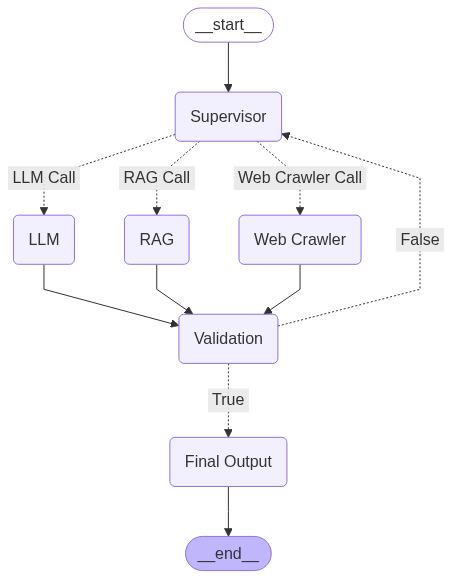

In [257]:
app

In [258]:
state = {"messages": ["is there any war ongoing on USA"]}
result = app.invoke(state)
result

supervisor fucntion
router function
rag function
validation function 0
supervisor fucntion
router function
rag function
validation function 0
supervisor fucntion
router function
rag function
validation function 10
final output function


{'messages': ['is there any war ongoing on USA',
  'related to USA',
  'RAG',
  "I don't know.  The provided text only gives an overview of the U.S. economy and doesn't mention any ongoing wars.",
  'Validated with rating 0',
  'related to USA',
  'RAG',
  "The provided text only gives an overview of the U.S. economy and doesn't mention any ongoing wars.  I don't know.",
  'Validated with rating 0',
  'related to USA',
  'RAG',
  "The provided text does not contain information about ongoing wars in the USA.  I don't know.",
  'Validated with rating 10',
  'completed']}

In [259]:
import json
with open("output.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

In [260]:
state

{'messages': ['is there any war ongoing on USA']}